In [1]:
import pandas as pd
import numpy as np
ratings_data=pd.read_csv('C:#########amazon.csv')

In [2]:
ratings_data=ratings_data[ratings_data['rating'] != "|"]

In [3]:
##creating the new dataset here
prod_id=[]
prod_desc=[]
user=[]
prod_name=[]
prod_cat=[]
prod_rating=[]

for i in range(0,len(ratings_data)):
    ##print(i)
    diff_id=ratings_data['user_id'][i].split(',')
    
    user.append(diff_id)
    prod_id.append([ratings_data['product_id'][i] for x in range(0,len(diff_id))])
    prod_desc.append([ratings_data['about_product'][i] for x in range(0,len(diff_id))])
    prod_name.append([ratings_data['product_name'][i] for x in range(0,len(diff_id))])
    prod_cat.append([ratings_data['category'][i] for x in range(0,len(diff_id))])
    prod_rating.append([ratings_data['rating'][i] for x in range(0,len(diff_id))])
    
import itertools
new_frame=pd.DataFrame()

new_frame['user_id']=list(itertools.chain.from_iterable(user))
new_frame['product_id']=list(itertools.chain.from_iterable(prod_id))
new_frame['about_product']=list(itertools.chain.from_iterable(prod_desc))
new_frame['product_name']=list(itertools.chain.from_iterable(prod_name))
new_frame['category']=list(itertools.chain.from_iterable(prod_cat))
new_frame['rating']=list(itertools.chain.from_iterable(prod_rating))

ratings_data=new_frame

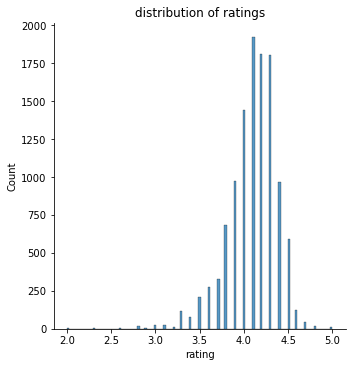

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(ratings_data['rating'])
plt.title('distribution of ratings')
plt.show()

In [5]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

reader=Reader(rating_scale=(.1,5))
data=Dataset.load_from_df(ratings_data[['user_id','product_id','rating']],reader)
algo=SVD()
cross_validate(algo,data,measures=['RMSE','MAE'],cv=5,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1743  0.1767  0.1985  0.1807  0.1839  0.1828  0.0085  
MAE (testset)     0.1300  0.1300  0.1353  0.1325  0.1355  0.1327  0.0024  
Fit time          0.15    0.17    0.15    0.12    0.12    0.14    0.02    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([0.17429066, 0.17671356, 0.19846004, 0.18065715, 0.18388567]),
 'test_mae': array([0.13001897, 0.13004709, 0.13534796, 0.13250999, 0.13554132]),
 'fit_time': (0.1508951187133789,
  0.17190194129943848,
  0.1459345817565918,
  0.12193107604980469,
  0.1219170093536377),
 'test_time': (0.011992692947387695,
  0.014991044998168945,
  0.010989189147949219,
  0.010993719100952148,
  0.012007474899291992)}

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix=tfidf.fit_transform(ratings_data['about_product'])

In [7]:
def get_cf_recommendations(user_id,n):
    
    user_products=ratings_data[ratings_data['user_id']==user_id]
    
    reader = Reader(rating_scale=(0.1,5))
    
    data=Dataset.load_from_df(user_products[['user_id','product_id','rating']],reader)
    
    algo=SVD()
    trainset=data.build_full_trainset()
    algo.fit(trainset)
    
    product_ids=ratings_data['product_id'].unique()
    
    for product_id in user_products['product_id']:
        if product_id in product_ids:
            product_ids.tolist().remove(product_id)
    predictions = []
    for product_id in product_ids:
        predictions.append((product_id,algo.predict(user_id,product_id).est))
    
    top_n_predictions=sorted(predictions,key=lambda x: x[1],reverse=True)[:n]
    top_n_product_ids=[x[0] for x in top_n_predictions]
    top_n_products=ratings_data[ratings_data['product_id'].isin(top_n_product_ids)]
    
    return top_n_products[['product_name','category']]

In [8]:
def get_cb_recommendations(user_id,n):
    
    user_products=ratings_data[ratings_data['user_id']==user_id]
    
    cosine_sim_matrix=cosine_similarity(tfidf_matrix,tfidf_matrix)
    
    recommended_products=[]
    for product_id in user_products['product_id']:
        product_index=ratings_data[ratings_data['product_id']==product_id].index[0]
        product_scores=list(enumerate(cosine_sim_matrix[product_index]))
        sorted_products=sorted(product_scores,key=lambda x: x[1],reverse=True)[1:n+1]
        recommended_products+= sorted_products
        
    recommended_product_ids = [x[0] for x in recommended_products]
    recommended_products_data=ratings_data[ratings_data['product_id'].isin(recommended_product_ids)]
    top_n_products=recommended_products_data.groupby(['product_id','product_name','category'])['product_id'].count().reset_index(name='count').sort_values(['count'],ascending=False).head(n)
    
    return top_n_products[['product_name','category']]

In [9]:
def get_hybrid_recommendations(user_id,n):
    
    cf_recommendations = get_cf_recommendations(user_id,n*2)
    cb_recommendations = get_cb_recommendations(user_id,n*2)
    
    hybrid_recommendations=pd.concat([cf_recommendations,cb_recommendations]).groupby(['product_name','category'])['product_name'].count().reset_index(name='count').sort_values(['count'],ascending=False).head(n)
    
    return hybrid_recommendations[['product_name','category']]

In [10]:
get_hybrid_recommendations(ratings_data['user_id'][10],10)

,product_name,category
10,Portronics Konnect L 1.2M POR-1401 Fast Chargi...,Computers&Accessories|Accessories&Peripherals|...
8,Portronics Konnect CL 20W POR-1067 Type-C to 8...,Computers&Accessories|Accessories&Peripherals|...
16,"boAt Micro USB 55 Tangle-free, Sturdy Micro US...",Computers&Accessories|Accessories&Peripherals|...
15,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...
14,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...
12,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...
11,Portronics Konnect L POR-1081 Fast Charging 3A...,Computers&Accessories|Accessories&Peripherals|...
9,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...
19,pTron Solero TB301 3A Type-C Data and Fast Cha...,Computers&Accessories|Accessories&Peripherals|...
7,MI Usb Type-C Cable Smartphone (Black),Computers&Accessories|Accessories&Peripherals|...
